# Marcer-Marchisciana
**Andrea Marcer - 10537040**

**Matteo Marchisciana - 10586574**

In this homework, we tried different models and approaches to tackle the problem. The architecture we tested are:
- Custom architecture Unet-like
- VGG + UNet

Moreover we tried some techniques to improve the quality of the input:
- Tiling
- Enhanced images

Here we give a brief description of each approach and why we used it.

## Tiling
At the start we tried to feed to the network the whole image, but we ran into problems regarding resources and loss of detaild due to interpolation caused by the resizing of the image. Given the large dimention of the dataset's images and the fact that our resources were limited, we chose to divide the original image in tiles with 256x256 as dimention and fed them to the network. Thanks to this we were able to preserve the details of the original image and to, in a way, increase the dataset dimension. Also in order to preserve the edges as crisp as possible, no resizing is performed, but instead we pad the image so that its dimentions are a multiple of the tile_size.

## Enhanced images
Since the network needs to distinguish between terrain and plant, and the first one is generally brown and the second is green, we performed some preprocessing on the images to increase contrast between background and plants. We used Matlab to perform this procedure (the file used can be found as an attachment in the homework folder). 
Using the code that can be found in *imagepreprocessing.mlx* we analized the images. Looking at the three channels we can easily see that the blue channel is very low in the portion of the image where there is a plant. Moreover if we look at the red channel (leftmost image) and the green channel (center image) we can see that the terrain has similar values of red and green, instead plants have fewer red than green. So at the end the transformation used for the enhancement is new_pixel_value = (red - green) / blue. 



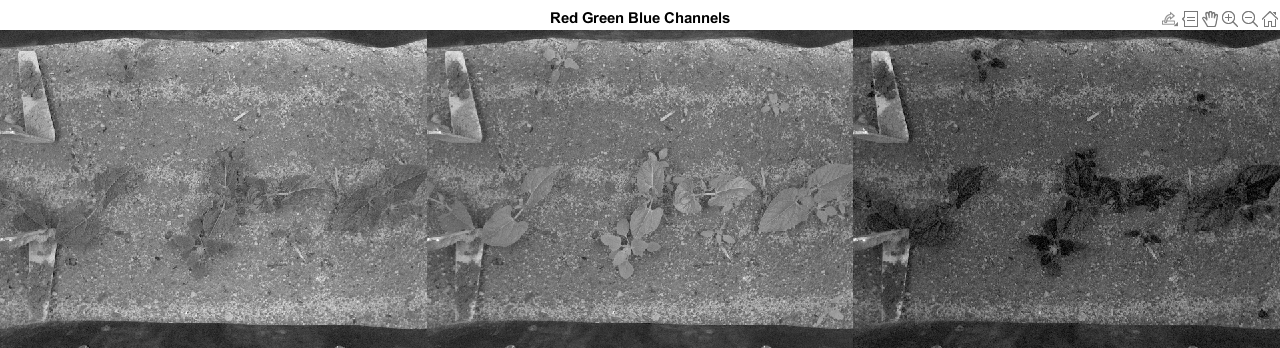

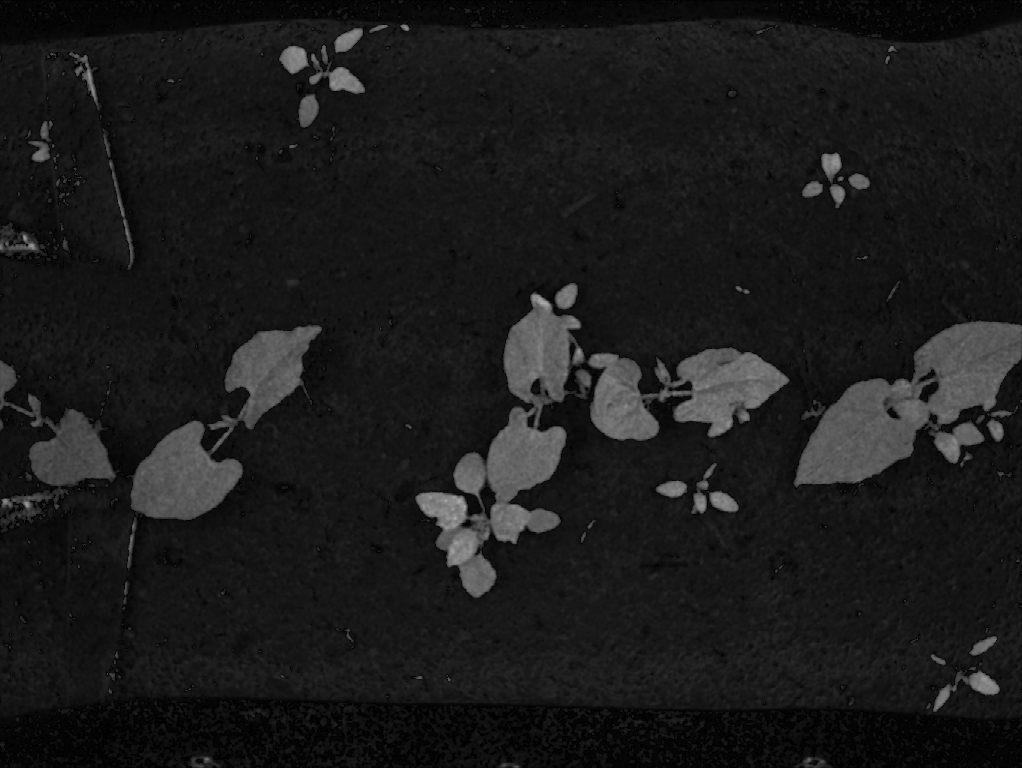

As we can see the output is a gray-scale image that makes it easier to spot plants. The enhancement has been optimized only for the BipBip dataset, but works well also for Weedelec's. Since the image is still noisy and could lead to some false weed detection, we decided to append to the original image the enhanced one to give to the network as much information as possible.

## Custom U-Net approach
We tried approaching the problem using a custom U-Net based on a very common architecture: 5 sets of 2 convolutions and a max pooling for the encoding part, then mirrored for the decoding, and a softmax layer at the end. Unfortunately, even after a lot of hyperparameters tuning (learning rate, filter number, initial image dimension, tiling size), the network wasn't able to identify the silhouette of the platns and in the end we discarded this approach.

## VGG + UNet
In this architecture we used VGG as a encoder and mirrored its structure for the decoder; while performing concatenation between layers at the same depth. We started training the network freezing all the VGG's layers and with an high learning rate. When the network reached a plateau in the loss we unlockded more layers and reduced the learning rate decreasing its order of magnitude. Moreover to reduce overfitting caused by the large number of parameters we introduced the 'l2' normalization and a dropout layer in the deepest point of the network as weel as augmentation. For the sake of this competition we trained the network only with BipBip's and Weedelec's datasets since they are similar end the enhancement achieved intended results on both of them.

##Submission
For the final submission, we split the image in tiles of 256x256, applying padding to the original image in order to make its height and its width a multiple of 256. After normalizing the original image, we created a batch composed by its tiles and fed it to the model. After taking the argmax of the prediction, we recombined the tiles into an image of the initial padded shape, and then stripped the padding from the image.

After analyzing the predicted masks, we noticed that tiling the image makes the prediction less accurate, especially on the edges of the tile. For example, we have that part of crops in the corners with weeds in the tile are classified as weeds, while for the adjacent tile it is classified correctly as a crop. However, we saw that tiling the image and keeping the original resolution was better than scaling the image to a lower resolution and feeding it to the network as a whole.

We also saw, with earlier models, that if the prediction was very noisy, the json produced with the RLE encoding of the image was very heavy, reaching sizes of 200MB, while for less noisy and more crisp prediction that didn't happen. It made it impractical to upload these jsons to CodaLab for testing the model.

## Results
In the end the model that performed the best was the VGG + UNet with l2 normalization reachinh an accuracy of ~69% on both Weedelec's and BipBip's datasets.

# Initialization

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import math
import matplotlib.pyplot as plt
import random as rand


import json

import tensorflow.keras.backend as K
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l1, l2, l1_l2
from datetime import datetime
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
############################ SETTINGS ############################
SEED = 941276
verbose = 0;
##################################################################

cwd = os.getcwd()
tf.random.set_seed(SEED)
np.random.seed(SEED)
rand.seed(SEED)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("cwd: " + cwd)

cwd: /content


# Dataset

In [4]:
###################################################################
bs = 42
num_classes = 3

img_h = 256
img_w = 256
channels = 4 # RGB + the enhanced image

tile_size = 256
###################################################################

In [5]:
# Converts the RGB mask image into a single matrix with category for each pixel 
def read_rgb_mask(mask_arr):
  new_target = np.zeros((mask_arr.shape[0],mask_arr.shape[1], 1), dtype=np.int8)
  new_target[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
  new_target[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
  return new_target

# Converts a mask to rgb
def mask_to_rgb(y_):
  new_target = np.zeros((y_.shape[0], y_.shape[1], 3), dtype = np.int8)
  mask_arr = np.array(y_, dtype=np.int8)
  new_target[np.where(mask_arr == 1)] = (255,255,255)
  new_target[np.where(mask_arr == 2)] = (216,67,82)
  return new_target.astype(np.uint8)

# Custom Data Generator used to load images from the memory and feed them to the network
class CustomDataset(tf.keras.utils.Sequence):
    
    def __init__(self, which_subset, img_generator=None, out_shape=[img_h, img_w]):
        self.which_subset = which_subset
        self.img_generator = img_generator
        self.out_shape = out_shape

    def __len__(self):
      if self.which_subset == 'training':
        return len(train_imgs)
      else:
        return len(valid_imgs)

    def __getitem__(self, index):
        if self.which_subset == 'training':
          img_arr = train_imgs[index]
          pro_arr = train_pro[index]
          mask_arr = train_masks[index]
          if self.img_generator is not None:  # If the data generator is associated to the training set augmentation is applied to the images
              img_t = self.img_generator.get_random_transform(self.out_shape)
              img_arr = self.img_generator.apply_transform(img_arr, img_t)
              pro_arr = self.img_generator.apply_transform(pro_arr, img_t)
              mask_arr = self.img_generator.apply_transform(mask_arr, img_t)
        else:
          img_arr = valid_imgs[index]
          pro_arr = valid_pro[index]
          mask_arr = valid_masks[index]
          
        # We append the henanced image to the RGB one
        result_img = np.concatenate((img_arr, pro_arr[:,:,0:1]), axis=2) 
        # Convert the mask from RGB to categorical
        mask_arr = read_rgb_mask(mask_arr)
        return np.float32(np.divide(result_img,255)), np.float32(mask_arr)

In [6]:
##################################################################################
dataset_dir = "/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/Merged"
#dataset_dir = '/content/drive/MyDrive/Homeworks/Homework 2/Merged'
#dataset_dir = "/content/drive/MyDrive/Università/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/Merged"
##################################################################################

# List of the images filenames in the dataset
subset_filenames = os.listdir(os.path.join(dataset_dir, 'Images'))

In [ ]:
for name in subset_filenames:
  print(name)
len(subset_filenames)

In [ ]:

imgs = []
processeds = []
masks = []

# Define the tile size
windowsize_r = img_h
windowsize_c = img_w
offset = 0
    
# Load images and tile them
for i in range(len(subset_filenames)):
    filename = subset_filenames[i][0:-4]
    img = np.array((Image.open(os.path.join(dataset_dir, 'Images', filename + '.jpg'))))
    processed = np.array((Image.open(os.path.join(dataset_dir, 'Processed_reduced', filename + '.jpg'))))
    mask = np.array(Image.open(os.path.join(dataset_dir, 'Masks', filename + '.png')))

    (h, w, c) = processed.shape
    pad_r = (math.ceil(w/(windowsize_c - offset))) * (windowsize_c - offset) - w
    pad_b = (math.ceil(h/(windowsize_r - offset))) * (windowsize_r - offset) - h
    
    # Perform padding if image dimentions are not a multiple of the tile_size
    img = cv2.copyMakeBorder( img, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)
    print(filename + " " + str(processed.shape) + " -> " + str(pad_r) + ", " + str(pad_b) + " -> " + str(img.shape))
    processed = cv2.copyMakeBorder( processed, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)
    mask = cv2.copyMakeBorder( mask, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)

    # perform  tiling
    for r in range(0,processed.shape[0] - windowsize_r, windowsize_r - offset):
        for c in range(0,processed.shape[1] - windowsize_c, windowsize_c - offset):
            block_img = img[r:r+windowsize_r,c:c+windowsize_c]
            block_pro = processed[r:r+windowsize_r,c:c+windowsize_c]
            block_mask = mask[r:r+windowsize_r,c:c+windowsize_c]
            imgs.append(block_img)
            processeds.append(block_pro)
            masks.append(block_mask)

In [9]:
# shuffle the dataset
c = list(zip(imgs, masks, processeds))
rand.shuffle(c)
imgs, masks, processeds = zip(*c)

# Split the dataset into train and validation
train_imgs = list(imgs[0:int(len(imgs))])
train_pro = list(processeds[0:int(len(processeds))])
train_masks = list(masks[0:int(len(masks))])
valid_imgs =list( imgs[-int(0.05*len(imgs)):len(imgs)])
valid_pro = list(processeds[-int(0.05*len(processeds)):len(processeds)])
valid_masks = list(masks[-int(0.05*len(masks)):len(masks)])

In [ ]:
for name in os.listdir(os.path.join(dataset_dir, 'newImages')):
    filename = name[0:-4]
    img = np.array((Image.open(os.path.join(dataset_dir, 'newImages', filename + '.jpg'))))
    processed = np.array((Image.open(os.path.join(dataset_dir, 'Processed_reduced', filename + '.jpg'))))
    mask = np.array(Image.open(os.path.join(dataset_dir, 'Masks', filename + '.png')))

    (h, w, c) = processed.shape
    pad_r = (math.ceil(w/(windowsize_c - offset))) * (windowsize_c - offset) - w
    pad_b = (math.ceil(h/(windowsize_r - offset))) * (windowsize_r - offset) - h
    
    # Perform padding if image dimentions are not a multiple of the tile_size
    img = cv2.copyMakeBorder( img, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)
    print(filename + " " + str(processed.shape) + " -> " + str(pad_r) + ", " + str(pad_b) + " -> " + str(img.shape))
    processed = cv2.copyMakeBorder( processed, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)
    mask = cv2.copyMakeBorder( mask, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)

    # perform  tiling
    for r in range(0,processed.shape[0] - windowsize_r, windowsize_r - offset):
        for c in range(0,processed.shape[1] - windowsize_c, windowsize_c - offset):
            block_img = img[r:r+windowsize_r,c:c+windowsize_c]
            block_pro = processed[r:r+windowsize_r,c:c+windowsize_c]
            block_mask = mask[r:r+windowsize_r,c:c+windowsize_c]
            train_imgs.append(block_img)
            train_pro.append(block_pro)
            train_masks.append(block_mask)

In [11]:
# Define transformations for augmentation
train_img_data_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=8,
    height_shift_range=8,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

# defint custom dataa generators
train_data_gen = CustomDataset(which_subset='training', img_generator = train_img_data_gen)
valid_data_gen = CustomDataset(which_subset='validation')
print(train_data_gen.__len__(), len(train_imgs))
print(valid_data_gen.__len__())

7350 7350
315


In [12]:
# define datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([img_h, img_w, channels], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(
    lambda: valid_data_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=([img_h, img_w, channels], [img_h, img_w, 1]))

valid_dataset = valid_dataset.batch(bs)
valid_dataset = valid_dataset.repeat()

## TESTING

In [ ]:
###################################################################
bs = 24
num_classes = 3

img_h = 256
img_w = 256
channels = 4 # RGB + the enhanced image

tile_size = 256
###################################################################

In [ ]:
##################################################################################
#dataset_dir = "/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/Merged"
dataset_dir = '/content/drive/MyDrive/Homeworks/Homework 2/Merged'
##################################################################################

# List of the images filenames in the dataset
subset_filenames = os.listdir(os.path.join(dataset_dir, 'Images'))
imgs = []
processeds = []
masks = []

# Define the tile size
windowsize_r = img_h
windowsize_c = img_w
offset = 0
    
# Load images and tile them
for i in range(180):#len(subset_filenames)):
    filename = subset_filenames[i][0:-4]
    img = np.array((Image.open(os.path.join(dataset_dir, 'Images', filename + '.jpg'))))
    processed = np.array((Image.open(os.path.join(dataset_dir, 'Processed_reduced', filename + '.jpg'))))
    mask = np.array(Image.open(os.path.join(dataset_dir, 'Masks', filename + '.png')))

    (h, w, c) = processed.shape
    pad_r = (math.ceil(w/(windowsize_c - offset))) * (windowsize_c - offset) - w
    pad_b = (math.ceil(h/(windowsize_r - offset))) * (windowsize_r - offset) - h
    
    # Perform padding if image dimentions are not a multiple of the tile_size
    img = cv2.copyMakeBorder( img, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)
    print(filename + " " + str(processed.shape) + " -> " + str(pad_r) + ", " + str(pad_b) + " -> " + str(img.shape))
    processed = cv2.copyMakeBorder( processed, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)
    mask = cv2.copyMakeBorder( mask, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)

    # perform  tiling
    for r in range(0,processed.shape[0] - windowsize_r, windowsize_r - offset):
        for c in range(0,processed.shape[1] - windowsize_c, windowsize_c - offset):
            block_img = img[r:r+windowsize_r,c:c+windowsize_c]
            block_pro = processed[r:r+windowsize_r,c:c+windowsize_c]
            block_mask = mask[r:r+windowsize_r,c:c+windowsize_c]
            imgs.append(block_img)
            processeds.append(block_pro)
            masks.append(block_mask)

In [ ]:
# shuffle the dataset
c = list(zip(imgs, masks, processeds))
rand.shuffle(c)
imgs, masks, processeds = zip(*c)

# Split the dataset into train and validation
train_imgs = imgs[0:int(len(imgs))]
train_pro = processeds[0:int(len(processeds))]
train_masks = masks[0:int(len(masks))]
valid_imgs = imgs[-int(0.05*len(imgs)):len(imgs)]
valid_pro = processeds[-int(0.05*len(processeds)):len(processeds)]
valid_masks = masks[-int(0.05*len(masks)):len(masks)]

In [ ]:
# Converts the RGB mask image into a single matrix with category for each pixel 
def read_rgb_mask(mask_arr):
  new_target = np.zeros((mask_arr.shape[0],mask_arr.shape[1], 1), dtype=np.int8)
  new_target[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
  new_target[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
  return new_target

# Converts a mask to rgb
def mask_to_rgb(y_):
  new_target = np.zeros((y_.shape[0], y_.shape[1], 3), dtype = np.int8)
  mask_arr = np.array(y_, dtype=np.int8)
  new_target[np.where(mask_arr == 1)] = (255,255,255)
  new_target[np.where(mask_arr == 2)] = (216,67,82)
  return new_target.astype(np.uint8)

# Custom Data Generator used to load images from the memory and feed them to the network
class CustomDataset(tf.keras.utils.Sequence):
    
    def __init__(self, which_subset, img_generator=None, out_shape=[img_h, img_w]):
        self.which_subset = which_subset
        self.img_generator = img_generator
        self.out_shape = out_shape
        self.on_epoch_end()

    def on_epoch_end(self):
      self.indexes = np.arange(len(train_imgs))
      np.random.shuffle(self.indexes)

    def __len__(self):
      if self.which_subset == 'training':
        return len(train_imgs) // bs
      else:
        return len(valid_imgs) // bs

    def __getitem__(self, index):
      
      indexes = self.indexes[index*bs:(index+1)*bs]
      x = []
      y = []
      for i in indexes:
        if self.which_subset == 'training':
          img_arr = train_imgs[i]
          pro_arr = train_pro[i]
          mask_arr = train_masks[i]
          if self.img_generator is not None:  # If the data generator is associated to the training set augmentation is applied to the images
              img_t = self.img_generator.get_random_transform(self.out_shape)
              img_arr = self.img_generator.apply_transform(img_arr, img_t)
              pro_arr = self.img_generator.apply_transform(pro_arr, img_t)
              mask_arr = self.img_generator.apply_transform(mask_arr, img_t)
        else:
          img_arr = valid_imgs[i]
          pro_arr = valid_pro[i]
          mask_arr = valid_masks[i]
          
        # We append the henanced image to the RGB one
        result_img = np.concatenate((img_arr, pro_arr[:,:,0:1]), axis=2) 

        x.append(np.float32(np.divide(result_img,255)))
        # Convert the mask from RGB to categorical
        mask_arr = read_rgb_mask(mask_arr)
        y.append(np.float32(mask_arr))
      return np.array(x), np.array(y)

In [ ]:
# Define transformations for augmentation
train_img_data_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=10,
    height_shift_range=10,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

# defint custom dataa generators
train_data_gen = CustomDataset(which_subset='training', img_generator = train_img_data_gen)
valid_data_gen = CustomDataset(which_subset='validation')
print(train_data_gen.__len__())
print(valid_data_gen.__len__())

262
13


## Test dataset

In [ ]:
x, y = train_data_gen[0]
train_data_gen.on_epoch_end()
for i in range(bs):
    processed = np.zeros([img_h, img_w, 3], dtype = np.float32)
    target_img = np.zeros([img_h, img_w, 3], dtype = np.int32)
    target = np.zeros([img_h, img_w, 1], dtype = np.float32)
    img = np.array(x[i][:,:,0:3], dtype=np.float32)
    target = np.array(y[i][:,:,0], dtype=np.float32)
    processed[:,:,:] = np.array(x[i][:,:,3:4], dtype=np.float32)
    fig, ax = plt.subplots(1, 3, figsize=(8,8))

    ax[0].imshow(img)

    target_img[np.where(target == 1.0)] = (255,255,255)
    target_img[np.where(target == 2.0)] = (216,67,82)
    ax[1].imshow(target_img)

    ax[2].imshow(processed)
    plt.show()

In [ ]:
# create iteretor of the dataset
dataset = iter(valid_dataset)

In [ ]:
#print images from the dataset
for batch in dataset:
  print(batch[0].shape)
  print(batch[1].shape)
  print("batch length: " + str(len(batch[0])))
  for i in range(0,len(batch[0])):
    processed = np.zeros([img_h, img_w, 3], dtype = np.float32)
    target_img = np.zeros([img_h, img_w, 3], dtype = np.int32)
    target = np.zeros([img_h, img_w, 1], dtype = np.float32)
    img = np.array(batch[0][i][:,:,0:3], dtype=np.float32)
    target = np.array(batch[1][i][:,:,0], dtype=np.float32)
    processed[:,:,:] = np.array(batch[0][i][:,:,3:4], dtype=np.float32)
    fig, ax = plt.subplots(1, 3, figsize=(8,8))

    ax[0].imshow(img)

    target_img[np.where(target == 1.0)] = (255,255,255)
    target_img[np.where(target == 2.0)] = (216,67,82)
    ax[1].imshow(target_img)

    ax[2].imshow(processed)
    plt.show()

# Model

## Custom Unet


In [ ]:
##################################################
depth = 5
filters=64
##################################################

layers = []
inputs = Input(shape=(img_w, img_h, channels)) 
x = inputs

for i in range (0,depth):
    x = Conv2D(
      filters=filters,
      kernel_size=(3,3),
      kernel_initializer=tf.keras.initializers.VarianceScaling(),
      padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(
      center=True,
      scale=True,
      fused=True)(x)
    x = tf.keras.activations.elu(x)

    x = Conv2D(
      filters=filters,
      kernel_size=(3,3),
      kernel_initializer=tf.keras.initializers.VarianceScaling(),
      padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(
      center=True,
      scale=True,
      fused=True)(x)
    x = tf.keras.activations.elu(x)

    layers.append(x)

    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

    filters *= 2

##################################################

x = Conv2D(
  filters=filters,
  kernel_size=(3,3),
  kernel_initializer=tf.keras.initializers.VarianceScaling(),
  padding = 'same')(x)
x = tf.keras.layers.BatchNormalization(
  center=True,
  scale=True,
  fused=True)(x)
x = tf.keras.activations.elu(x)

x = Dropout(0.5)(x)

x = Conv2D(
  filters=filters,
  kernel_size=(3,3),
  kernel_initializer=tf.keras.initializers.VarianceScaling(),
  padding = 'same')(x)
x = tf.keras.layers.BatchNormalization(
  center=True,
  scale=True,
  fused=True)(x)
x = tf.keras.activations.elu(x)

x = Dropout(0.5)(x)

# ##################################################

for i in range (0,depth):
    filters //= 2
    
    x = UpSampling2D(size = (2,2), interpolation = 'bilinear')(x)
    x = Conv2D(
      filters=filters,
      kernel_size=(3,3),
      kernel_initializer=tf.keras.initializers.VarianceScaling(),
      padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(
      center=True,
      scale=True,
      fused=True)(x)
    x = tf.keras.activations.elu(x)
    
    x = concatenate([x,layers[depth-i-1]], axis = 3)

    x = Conv2D(
      filters=filters,
      kernel_size=(3,3),
      kernel_initializer = tf.keras.initializers.VarianceScaling(),
      padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(
      center=True,
      scale=True,
      fused=True)(x)
    x = tf.keras.activations.elu(x)

x = Conv2D(
  filters=num_classes,
  kernel_size=(1,1),
  kernel_initializer=tf.keras.initializers.VarianceScaling(),
  activation = 'softmax',
  padding = 'same')(x)

model = Model(inputs=inputs, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.elu (TFOpLambda)          (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

## Custom Unet 2


In [ ]:
##################################################
depth = 6
filters=64
##################################################

layers = []
filter_layer = []
inputs = Input(shape=(img_w, img_h, channels)) 
x = inputs

for i in range (0,depth):

    filter_layer.append(filters)
    print(filters)

    x = Conv2D(
      filters=filters,
      kernel_size=(3,3),
      kernel_initializer=tf.keras.initializers.VarianceScaling(),
      padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(
      center=True,
      scale=True,
      fused=True)(x)
    x = tf.keras.activations.elu(x)

    layers.append(x)

    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)

    filters = min(512, filters * 2)
    

##################################################

x = Dropout(0.5)(x)

x = Conv2D(
  filters=1024,
  kernel_size=(3,3),
  kernel_initializer=tf.keras.initializers.VarianceScaling(),
  padding = 'same')(x)
x = tf.keras.layers.BatchNormalization(
  center=True,
  scale=True,
  fused=True)(x)
x = tf.keras.activations.elu(x)

x = Dropout(0.5)(x)
print("-------")
# ##################################################

for i in range (0,depth):
    filters = filter_layer[depth-i-1]
    print(filters)
    
    x = UpSampling2D(size = (2,2), interpolation = 'bilinear')(x)
    x = Conv2D(
      filters=filters,
      kernel_size=(3,3),
      kernel_initializer=tf.keras.initializers.VarianceScaling(),
      padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(
      center=True,
      scale=True,
      fused=True)(x)
    x = tf.keras.activations.elu(x)
    
    x = concatenate([x,layers[depth-i-1]], axis = 3)

    x = Conv2D(
      filters=filters,
      kernel_size=(3,3),
      kernel_initializer = tf.keras.initializers.VarianceScaling(),
      padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(
      center=True,
      scale=True,
      fused=True)(x)
    x = tf.keras.activations.elu(x)

x = Conv2D(
  filters=num_classes,
  kernel_size=(1,1),
  kernel_initializer=tf.keras.initializers.VarianceScaling(),
  activation = 'softmax',
  padding = 'same')(x)

model = Model(inputs=inputs, outputs=x)

model.summary()

64
128
256
512
512
512
-------
512
512
512
256
128
64
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.elu (TFOpLambda)          (None, 256, 256, 64) 0           batch_normalization[0][0]        
________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

## VGG + Unet

In [ ]:
###############################################################################
lambda_conv = 0.01
freeze_until = 18 # layers of the VGG to freeze
###############################################################################

# Structure and weight of VGG16 with regularization
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[img_h, img_w, 3])

inputs = Input(shape=(img_w, img_h, channels)) 

# Block 1
conv1 = Conv2D(64, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block1_conv1',
                        input_shape=(256, 256, 3))(inputs)
conv2 = Conv2D(64, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block1_conv2')(conv1)
max1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(conv2)

# Block 2
conv3 = Conv2D(128, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block2_conv1')(max1)
conv4 = Conv2D(128, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block2_conv2')(conv3)
max2 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(conv4)

# Block 3
conv5 = Conv2D(256, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block3_conv1')(max2)
conv6 = Conv2D(256, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block3_conv2')(conv5)
conv7 = Conv2D(256, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block3_conv3')(conv6)
max3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(conv7)

# Block 4
conv8 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block4_conv1')(max3)
conv9 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block4_conv2')(conv8)
conv10 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block4_conv3')(conv9)
max4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(conv10)

# Block 5
conv11 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block5_conv1')(max4)
con12 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block5_conv2')(conv11)
conv13 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block5_conv3')(con12)
max5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(conv13)

##################################################

conv16 = Conv2D(
    filters=1024,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(max5)

drop17 = Dropout(0.4)(conv16)

##################################################

up18 = UpSampling2D(size = (2,2), interpolation='bilinear')(drop17)
conv18 = Conv2D(
    filters=512, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up18)
merge18 = concatenate([conv13,conv18], axis = 3)

conv19 = Conv2D(
    filters=512,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge18)

conv20 = Conv2D(
    filters=512,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(conv19)

##################################################

up22 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv20)
conv22 = Conv2D(
    filters=512, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up22)
merge22 = concatenate([conv10,conv22], axis = 3)

conv23 = Conv2D(
    filters=512,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge22)

conv24 = Conv2D(
    filters=512,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(conv23)

##################################################

up26 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv24)
conv26 = Conv2D(
    filters=256, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up26)
merge26 = concatenate([conv7,conv26], axis = 3)

conv27 = Conv2D(
    filters=256,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge26)

conv28 = Conv2D(
    filters=256,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(conv27)

##################################################

up30 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv28)
conv30 = Conv2D(
    filters=128, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up30)
merge30 = concatenate([conv4,conv30], axis = 3)

conv31 = Conv2D(
    filters=128,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge30)

conv32 = Conv2D(
    filters=128,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(conv31)

##################################################

up34 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv32)
conv34 = Conv2D(
    filters=64, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up34)
merge34 = concatenate([conv2,conv34], axis = 3)

conv36 = Conv2D(
    filters=64,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge34)

conv39 = Conv2D(
    filters=3,
    kernel_size=(1,1),
    activation = 'softmax',
    padding = 'same')(conv36)

##################################################

model = Model(inputs=inputs, outputs=conv39)

# freeze layers
for layer in model.layers[2:freeze_until]:
    layer.trainable = False

# Load weight from the VGG
for i in range(2,19):
    model.layers[i].set_weights(vgg.layers[i].get_weights())

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 2368        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_____________________________

## Simplified VGG+UNet

In [ ]:
###############################################################################
lambda_conv = 0.001
freeze_until = 18 # layers of the VGG to freeze
###############################################################################

# Structure and weight of VGG16 with regularization
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[img_h, img_w, 3])

inputs = Input(shape=(img_w, img_h, channels)) 

# Block 1
conv1 = Conv2D(64, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block1_conv1',
                        input_shape=(256, 256, 3))(inputs)
conv2 = Conv2D(64, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block1_conv2')(conv1)
max1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(conv2)

# Block 2
conv3 = Conv2D(128, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block2_conv1')(max1)
conv4 = Conv2D(128, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block2_conv2')(conv3)
max2 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(conv4)

# Block 3
conv5 = Conv2D(256, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block3_conv1')(max2)
conv6 = Conv2D(256, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block3_conv2')(conv5)
conv7 = Conv2D(256, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block3_conv3')(conv6)
max3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(conv7)

# Block 4
conv8 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block4_conv1')(max3)
conv9 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block4_conv2')(conv8)
conv10 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block4_conv3')(conv9)
max4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(conv10)

# Block 5
conv11 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block5_conv1')(max4)
con12 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block5_conv2')(conv11)
conv13 = Conv2D(512, (3, 3),
                        activation='selu',
                        padding='same',
                        kernel_regularizer=l2(lambda_conv),
                        bias_regularizer=l2(lambda_conv),
                        name='block5_conv3')(con12)
max5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(conv13)

##################################################

conv16 = Conv2D(
    filters=1024,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(max5)

drop17 = Dropout(0.4)(conv16)

##################################################

up18 = UpSampling2D(size = (2,2), interpolation='bilinear')(drop17)
conv18 = Conv2D(
    filters=512, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up18)
merge18 = concatenate([conv13,conv18], axis = 3)

conv20 = Conv2D(
    filters=512,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge18)

##################################################

up22 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv20)
conv22 = Conv2D(
    filters=512, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up22)
merge22 = concatenate([conv10,conv22], axis = 3)

conv24 = Conv2D(
    filters=512,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge22)

##################################################

up26 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv24)
conv26 = Conv2D(
    filters=256, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up26)
merge26 = concatenate([conv7,conv26], axis = 3)

conv28 = Conv2D(
    filters=256,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge26)

##################################################

up30 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv28)
conv30 = Conv2D(
    filters=128, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up30)
merge30 = concatenate([conv4,conv30], axis = 3)

conv32 = Conv2D(
    filters=128,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge30)

##################################################

up34 = UpSampling2D(size = (2,2), interpolation='bilinear')(conv32)
conv34 = Conv2D(
    filters=64, 
    kernel_size=(3,3),
    activation = 'selu', 
    padding = 'same')(up34)
merge34 = concatenate([conv2,conv34], axis = 3)

conv36 = Conv2D(
    filters=64,
    kernel_size=(3,3),
    activation = 'selu',
    padding = 'same')(merge34)

conv39 = Conv2D(
    filters=3,
    kernel_size=(1,1),
    activation = 'softmax',
    padding = 'same')(conv36)

##################################################

model = Model(inputs=inputs, outputs=conv39)

# freeze layers
for layer in model.layers[2:freeze_until]:
    layer.trainable = False

# Load weight from the VGG
for i in range(2,19):
    model.layers[i].set_weights(vgg.layers[i].get_weights())

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 2368        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

# Load model

In [ ]:
##################################################################
model_path = '/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/model_custom_bipbip_0789'
#model_path = '/content/drive/MyDrive/Homeworks/Homework 2/model_custom_v4'
#model_path = "/content/drive/MyDrive/Università/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/model_custom_bipbip_0789"
layers_to_freeze = 10
##################################################################

model = tf.keras.models.load_model(model_path, custom_objects={'meanIoU':meanIoU,'weedIoU':weedIoU,'cropIoU':cropIoU, 'custom_loss':custom_loss})

# freeze_until = layers_to_freeze # Layer from which we want to fine-tune.
# for layer in model.layers[:freeze_until]:
#     layer.trainable = False

model.summary()

# Training

In [13]:
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    return 1 - ((cropIoU(y_true, y_pred) + weedIoU(y_true, y_pred))/2)

def weedIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    class_pred = tf.cast(tf.where(y_pred == 2, 1, 0), tf.float32)
    class_true = tf.cast(tf.where(y_true == 2, 1, 0), tf.float32)
    intersection = tf.reduce_sum(class_true * class_pred)
    union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
        
    result = (intersection + 1e-7) / (union + 1e-7)
    #print("weed: " + str(result))
    return result

def cropIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    class_pred = tf.cast(tf.where(y_pred == 1, 1, 0), tf.float32)
    class_true = tf.cast(tf.where(y_true == 1, 1, 0), tf.float32)
    intersection = tf.reduce_sum(class_true * class_pred)
    union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
        
    result = (intersection + 1e-7) / (union + 1e-7)
    #print("weed: " + str(result))
    return result

ALPHA = 0.8
GAMMA = 2

# def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)
    
#     BCE = K.binary_crossentropy(targets, inputs)
#     BCE_EXP = K.exp(-BCE)
#     focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
#     return focal_loss

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    BCE = K.sparse_categorical_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss * (cropIoU(targets, inputs))**0.5

def DiceBCELoss(targets, inputs, smooth=1e-6):    
  BCE =  K.sparse_categorical_crossentropy(targets, inputs)
  #flatten label and prediction tensors
  inputs = K.flatten(inputs)
  targets = K.flatten(targets)
  print('qui')
  print(targets)
  print(inputs)
  intersection = K.sum(K.dot(targets, inputs))
  print('qui')
  dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
  print('qui')
  Dice_BCE = BCE + dice_loss
  
  return BCE#Dice_BCE


def custom_loss(y_true, y_pred):
    return ((meanIoU(y_true, y_pred))**0.5) + tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

In [16]:
##########################################################################
# for layer in model.layers[2:18]:
#     layer.trainable = False
# for layer in model.layers[0:18]:
#     layer.trainable = True

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy() #custom_loss

# learning rate
optimizer = tf.keras.optimizers.Adamax(
    learning_rate=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)
# optimizer = tf.keras.optimizers.RMSprop(
#     learning_rate=1e-3,
#     centered=True
# )

# Validation metrics
metrics = ['accuracy', meanIoU, weedIoU, cropIoU]
##########################################################################


# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.elu (TFOpLambda)          (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [21]:
##########################################################################
# where to save model in model checkpoint

#filepath = '/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/model_custom_v3'
filepath = '/content/drive/MyDrive/Homeworks/Homework 2/model_custom_newdata_v1'
##########################################################################

callback_list = []
modelcheckpoint = False

# Early stopping
es = EarlyStopping(
    monitor = 'meanIoU',
    min_delta = 0, 
    patience = 15,
    verbose = verbose,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True)
callback_list.append(es)

# Model Checkpoint
if(modelcheckpoint):
  cp = ModelCheckpoint(
      filepath=filepath,
      monitor='meanIoU',
      verbose=0,
      save_best_only=True,
      save_weights_only=False,
      mode='auto',
      save_freq="epoch")
  callback_list.append(cp)

# At the end of each epoch predict an image of the training and one of the test 
# and saves it in the current folder. This is used to understand of the network is learning
def PrintPrediction(epoch, logs):
  test_dir = "/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/Test_Dev_1/Bipbip/Haricot"
  #test_dir = '/content/drive/MyDrive/Homeworks/Homework 2/Test_Dev_1/Bipbip/Haricot'
  test_image_name = "Bipbip_haricot_im_00581.jpg"
  test_image_path = os.path.join(test_dir, "Images", test_image_name)
  test_bw_path = os.path.join(test_dir,"processed", test_image_name)

  test_image = np.array(Image.open(test_image_path))
  test_bw = np.array(Image.open(test_bw_path))

  test_image_combined = np.concatenate((test_image, test_bw[:,:,0:1]), axis=2)

  prediction = predict_image(test_image_combined)
  prediction = mask_to_rgb(prediction)
  img = Image.fromarray(prediction, 'RGB')
  img.save("prediction_test.png")

  test_dir = "/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/Merged/"
  #test_dir = "/content/drive/MyDrive/Homeworks/Homework 2/Merged/"
  test_image_name = "Bipbip_haricot_im_05111.jpg"
  test_image_path = os.path.join(test_dir, "Images", test_image_name)
  test_bw_path = os.path.join(test_dir,"Processed_reduced", test_image_name)

  test_image = np.array(Image.open(test_image_path))
  test_bw = np.array(Image.open(test_bw_path))

  test_image_combined = np.concatenate((test_image, test_bw[:,:,0:1]), axis=2)

  prediction = predict_image(test_image_combined)
  prediction = mask_to_rgb(prediction)
  img = Image.fromarray(prediction, 'RGB')
  img.save("prediction_train.png")

print_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=PrintPrediction)
callback_list.append(print_callback)

In [22]:
#############################################################
epochs = 50
#############################################################

model.fit(
    x = train_dataset,
    epochs = epochs,
    steps_per_epoch = train_data_gen.__len__()//bs,
    validation_data = valid_dataset,
    validation_steps = valid_data_gen.__len__()//bs,
    callbacks = callback_list)

Epoch 1/50
175/175 [==============================] - 670s 4s/step - loss: 0.0669 - accuracy: 0.9748 - meanIoU: 0.2223 - weedIoU: 0.7151 - cropIoU: 0.8402 - val_loss: 0.0771 - val_accuracy: 0.9701 - val_meanIoU: 0.2210 - val_weedIoU: 0.7004 - val_cropIoU: 0.8575
Epoch 2/50
175/175 [==============================] - 674s 4s/step - loss: 0.0662 - accuracy: 0.9751 - meanIoU: 0.2187 - weedIoU: 0.7192 - cropIoU: 0.8434 - val_loss: 0.0772 - val_accuracy: 0.9700 - val_meanIoU: 0.2211 - val_weedIoU: 0.7004 - val_cropIoU: 0.8573
Epoch 3/50
175/175 [==============================] - 663s 4s/step - loss: 0.0663 - accuracy: 0.9751 - meanIoU: 0.2192 - weedIoU: 0.7189 - cropIoU: 0.8428 - val_loss: 0.0770 - val_accuracy: 0.9702 - val_meanIoU: 0.2198 - val_weedIoU: 0.7020 - val_cropIoU: 0.8585
Epoch 4/50
175/175 [==============================] - 659s 4s/step - loss: 0.0660 - accuracy: 0.9752 - meanIoU: 0.2178 - weedIoU: 0.7207 - cropIoU: 0.8437 - val_loss: 0.0770 - val_accuracy: 0.9702 - val_meanIoU:

KeyboardInterrupt: ignored

# Save Model

In [ ]:
import gc
gc.collect()

190936

In [25]:
################ SAVE MODEL ################ 
save_dir = os.path.join('/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2', 'model_custom_v3')
############################################

model.save(save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/model_custom_v3/assets


# Submission

In [ ]:
test_dir = "/content/drive/MyDrive/Università/Artificial Neural Networks and Deep Learning/Datasets/Test_Dev"

In [15]:
# tiles the image
def do_tiling_new(image_):
  #(height, width, channels) = image_.shape
  (height, width, channels) = image_.shape
  ## R is right, B is bottom
  pad_r = (math.ceil(width/(tile_size))) * (tile_size) - width
  pad_b = (math.ceil(height/(tile_size))) * (tile_size) - height

  image_ = cv2.copyMakeBorder( image_, 0, pad_b, 0, pad_r, cv2.BORDER_REFLECT)/255

  h_tiles = image_.shape[0] // tile_size
  w_tiles = image_.shape[1] // tile_size
  tiles = []
  for h in range(h_tiles):
    for w in range(w_tiles):
      tiles.append(image_[h*tile_size : (h+1)*tile_size, w*tile_size : (w+1)*tile_size])

  return tiles, (h_tiles, w_tiles)

# given an array of tiles recontruct the original image
def unify(predicted_tiles_, prev_shape_, tile_num_):
  prediction_unified = np.zeros((tile_num_[0] * tile_size, tile_num_[1] * tile_size))
  argmax = tf.argmax(predicted_tiles_, 3)
  #print("unique:" + str(np.unique(argmax)))
  for row_tile in range(tile_num_[0]):
    for column_tile in range(tile_num_[1]):
      prediction_unified[ row_tile * tile_size : (row_tile+1) * tile_size,
                          column_tile * tile_size : (column_tile+1) * tile_size] = argmax[row_tile * tile_num_[1] + column_tile]
  
  return prediction_unified

# performs image prediction by tiling the image, colling the model and then unifying the prediction tiles
def predict_image(image_):
  img_shape = image_.shape[0:2]

  #print("Tiling image")
  tiled_image, tile_num = do_tiling_new(image_)
  tiles_modified = tf.convert_to_tensor(tiled_image)

  #print("Predicting image")
  model_prediction = model.predict(tiles_modified)
  
  #print("Unifying")
  prediction_unified = unify(model_prediction, img_shape, tile_num)
  
  # remove eventual padding
  prediction_unified = prediction_unified[0:img_shape[0], 0:img_shape[1]]

  #print("End")

  return prediction_unified.astype(np.uint8)

## Visualize

In [ ]:
## IMAGES WITH B&W CHANNEL
test_dir = '/content/drive/MyDrive/Homeworks/Homework 2/Test_Dev_1/Bipbip/Haricot'
test_image_name = "Bipbip_haricot_im_02421.jpg"
test_image_path = os.path.join(test_dir, "Images", test_image_name)
test_bw_path = os.path.join(test_dir,"processed", test_image_name)

test_image = np.array(Image.open(test_image_path))
test_bw = np.array(Image.open(test_bw_path))

test_image_combined = np.concatenate((test_image, test_bw[:,:,0:1]), axis=2)
print(test_image_combined.shape)

prediction = predict_image(test_image_combined)
prediction = mask_to_rgb(prediction)

fig, ax = plt.subplots(2, 1, figsize=(40,40))
ax[0].imshow(test_image)
ax[1].imshow(prediction)

# Submission JSON building

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(rle, shape):
  s = rle.split()
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths
  img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
  for lo, hi in zip(starts, ends):
      img[lo:hi] = 1
  return img.reshape(shape)

In [ ]:
#test_dir = "/content/drive/MyDrive/POLI/Artificial Neural Networks and Deep Learning/Homeworks/Homework 2/Test_Dev_1"
test_dir = "/content/drive/MyDrive/Homeworks/Homework 2/Test_Dev_1"
teams = ["Bipbip", "Pead", "Roseau", "Weedelec"]
crops = ["Haricot", "Mais"]
# teams = ["Pead", "Haricot", "Mais"]


submission_dict = {}

for team in teams:
  for crop in crops:
    path_before_images = os.path.join(test_dir, team, crop)
    current_path = os.path.join(test_dir, team, crop, "Images")
    image_names = os.listdir(current_path)

    for image_name in image_names:
      print("Processing " + image_name)
      fig, ax = plt.subplots(1, 2, figsize=(16,16))

      image = np.array(Image.open(os.path.join(current_path, image_name)))

      ax[0].imshow(image)

      bw = np.array(Image.open(os.path.join(path_before_images, "processed", image_name)))
      ## FOURTH CHANNEL B&W

      image = np.concatenate((image, bw[:,:,0:1]), axis=2)

      image_name = image_name[0:-4]
      prediction = predict_image(image)
      
      ax[1].imshow(prediction)

      submission_dict[image_name] = {}
      submission_dict[image_name]['shape'] = prediction.shape
      submission_dict[image_name]['team'] = team
      submission_dict[image_name]['crop'] = crop
      submission_dict[image_name]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(prediction == 1)
      # # weed
      rle_encoded_weed = rle_encode(prediction == 2)
      ##REVERSE ENCODING
      ##crop
      # rle_encoded_crop = rle_encode(prediction == 2)
      # ## weed
      # rle_encoded_weed = rle_encode(prediction == 1)
      

      submission_dict[image_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[image_name]['segmentation']['weed'] = rle_encoded_weed
      plt.show()
with open(os.path.join(test_dir, "submission.json"), 'w') as f:
  json.dump(submission_dict, f)


In [ ]:
# The submission file will be a zip file containing the a
# submission.json file.

# It must have the following structure:

# - image name (without any extension, e.g., png, jpg, etc.)
#   - shape: shape of the original image as list [Height, Width]
#   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
#   - crop: crop of the original image. One in {'Haricot', 'Mais'}
#   - segmentation: prediction (as a dict)
#     - crop: RLE encoded crop segmentation (no weed)
#     - weed: RLE encoded weed segmentation (no crop)

# Please refer to the folder structure of the given dataset to fill
# the team and crop keys.

# EXAMPLE:

# Suppose that the numpy array generated with the
# 'read_mask_example.py' script is the output of your segmentation model.
# In addition, suppose that the team and crop of the segmented image
# are 'Bipbip' and 'Haricot', respectively.
# Then, in the following an example of submission file.

img_name = 'arr_mask_example'

# load mask <- HERE you should have your segmentation model instead
mask_arr = np.load('./predictions/arr_mask_example.npy')

submission_dict = {}
submission_dict[img_name] = {}
submission_dict[img_name]['shape'] = mask_arr.shape
submission_dict[img_name]['team'] = 'Bipbip'
submission_dict[img_name]['crop'] = 'Haricot'
submission_dict[img_name]['segmentation'] = {}

# RLE encoding
# crop
rle_encoded_crop = rle_encode(mask_arr == 1)
# weed
rle_encoded_weed = rle_encode(mask_arr == 2)

submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

# Please notice that in this example we have a single prediction.
# For the competition you have to provide segmentation for each of
# the test images.

# Finally, save the results into the submission.json file
with open('./predictions/submission.json', 'w') as f:
    json.dump(submission_dict, f)